# Prediction of grant application (Ali, Maxime)

## Data processing functions

In [1]:
import numpy as np
import pandas as pd

#
# Contigency for persons
#
# build the list of all unique values of a given spread column, as a tuple
def process_column(data, prefix, nb_max):
    unique_values = set([])
    for i in range(1, nb_max+1):
        unique_values.update(data[prefix+str(i)].unique())
    return tuple(unique_values)

# Build a dataframe with contingecy frequencies from a given spread column
def add_contigency(prefix, nb_max, unique_values, add_cardinal, keep_nan):
    nb_unique_values = len(unique_values)
    has_nans = np.nan in unique_values
    nan_index = unique_values.index(np.nan)
    new_feature_labels = [prefix+str(value) for value in unique_values]
    if has_nans and not keep_nan:
        new_feature_labels.pop(nan_index)
    if add_cardinal:
        new_feature_labels.append("cardinal_"+prefix)
    def nested_func(x):
        values_frequency = [0]*nb_unique_values
        for i in range(1, nb_max+1):
            values_frequency[unique_values.index(x[prefix+str(i)])] += 1
        if has_nans:
            values_frequency[nan_index] = 0
            if not keep_nan:
                values_frequency.pop(nan_index)
        summe = sum(values_frequency)
        if summe != 0:
            values_frequency = [value/summe for value in values_frequency]
        if add_cardinal:
            values_frequency.append(summe)
        return pd.Series(values_frequency, index=new_feature_labels)
    return nested_func

# Build a dataframe with contingecy frequencies from a given spread column
def build_contigency(data, prefix, nb_max, add_cardinal=False, keep_nan=False):
    unique_values = process_column(data, prefix, nb_max)
    return unique_values, data.apply(add_contigency(prefix, nb_max, unique_values, add_cardinal, keep_nan), axis=1, raw=True)

#
# aggregations for person
#
# Build a dataframe with contingecy frequencies from a given spread column
def add_aggregation(prefixes, nb_max, methods_to_apply, methods_to_apply_labels):
    feature_names_by_prefix = [[prefix+str(i) for i in range(1, nb_max+1)] for prefix in prefixes]
    new_feature_labels_by_prefix = [[label_prefix+prefix for label_prefix in methods_to_apply_labels] for prefix in prefixes]
    flat_new_labels = [new_feature_label for new_feature_labels in new_feature_labels_by_prefix for new_feature_label in new_feature_labels]
    def nested_func(x):
        values_by_prefix = [
            [x[feature_name] for feature_name in feature_names if np.isreal(x[feature_name]) and not np.isnan(x[feature_name])]
            for feature_names in feature_names_by_prefix
        ]
        aggregated_values_by_prefix = [[method(values) for method in methods_to_apply] if len(values) > 0 else [np.nan]*len(methods_to_apply) for values in values_by_prefix]
        return pd.Series(
            data=[aggregated_value for aggregated_values in aggregated_values_by_prefix for aggregated_value in aggregated_values], 
            index=flat_new_labels
        )
    return nested_func
# Build a dataframe with contingecy frequencies from a given spread column
def build_aggregation(data, prefix, nb_max, methods_to_apply=[np.mean, np.max, np.min], methods_to_apply_labels=["mean_", "max_", "min_"]):
    return data.apply(add_aggregation(prefix, nb_max, methods_to_apply, methods_to_apply_labels), axis=1, raw=True)

#
# RFCD & SEO
#
def rfcd_codes(data, prefix, nb_max, length):
    unique_values = set([])
    for i in range(1, nb_max+1):
        unique_values.update([str(code)[:length] if not np.isreal(code) and code != "0" else np.nan for code in data[prefix+str(i)].unique()])
    return tuple(unique_values)

# Build a dataframe with contingecy frequencies from a given spread column
def add_rfcd_aggregation(prefix1, prefix2, nb_max, unique_values, add_cardinal, suffix, length, keep_nan):
    nb_unique_values = len(unique_values)
    has_nans = np.nan in unique_values
    nan_index = unique_values.index(np.nan)
    new_feature_labels = [prefix2+str(value)+suffix for value in unique_values]
    if has_nans and not keep_nan:
        new_feature_labels.pop(nan_index)
    if add_cardinal:
        new_feature_labels.append("cardinal_"+prefix2)
    def nested_func(x):
        values_percentage = [0]*nb_unique_values
        cardinal = 0
        for i in range(1, nb_max+1):
            considered_value = x[prefix1+str(i)]
            current_value =  np.nan
            if not np.isreal(considered_value) and considered_value != '0':
                current_value = str(considered_value)[:length]
                cardinal += 1
            values_percentage[unique_values.index(current_value)] += x[prefix2+str(i)]/100.0
        if has_nans:
            values_percentage[nan_index] = 0
            if not keep_nan:
                values_percentage.pop(nan_index)
        if add_cardinal:
            values_percentage.append(cardinal)
        return pd.Series(values_percentage, index=new_feature_labels)
    return nested_func

# Build a dataframe with contingecy frequencies from a given spread column
def build_rfcd_aggregation(data, prefix1, prefix2, nb_max, length, add_cardinal=True, suffix="x", keep_nan=False):
    unique_values = rfcd_codes(data, prefix1, nb_max, length)
    return unique_values, data.apply(add_rfcd_aggregation(prefix1, prefix2, nb_max, unique_values, add_cardinal, suffix, length, keep_nan), axis=1, raw=True)

#
# Parameters Search
#
from sklearn.grid_search import ParameterGrid

def grid_search_no_cv(parameters, X_train, X_test, y_train, y_test, classifier, parallel=True):

    grid_search = ParameterGrid(parameters)
    best_score = 0
    best_params = {}

    nb_gridsearch_folds = len(grid_search)
    for index, param in enumerate(grid_search):
        if parallel:
            current_classifier = classifier(**param, n_jobs=7)
        else:
            current_classifier = classifier(**param)
        prediction_proba = current_classifier.fit(X_train, y_train).predict_proba(X_test)
        current_score = roc_auc_score(np.array(y_test.values), prediction_proba[:, 1])
        flag_best = " "
        if current_score > best_score:
            best_score = current_score
            best_params = param
            flag_best = "*"
        print(flag_best+" %2d/%d | %f | %s" %(index+1, nb_gridsearch_folds, current_score, str(param)))
    return best_score, best_params

# Importing data

In [2]:
data = pd.read_csv("data/unimelb_training.csv", header=0, dtype="str")
data = data.drop("Unnamed: 251", axis=1)
data["Year"] = data["Start.date"].map(lambda x: float(x.split("/")[2]))
data["Month"] = data["Start.date"].map(lambda x: float(x.split("/")[1]))


numerical_data_feature_category = [
    ("RFCD.Percentage.", 5),
    ("SEO.Percentage.", 5), 
    ("Year.of.Birth.", 15),
    ("Number.of.Successful.Grant.", 15),
    ("Number.of.Unsuccessful.Grant.", 15),
    ("A..", 15),
    ("A.", 15),
    ("B.", 15),
    ("C.", 15)
]

for feature_name, feature_range in numerical_data_feature_category:
    numerical_data_features = [feature_name+str(i) for i in range(1, feature_range+1)]
    for numerical_data_feature in numerical_data_features:
        data[numerical_data_feature] = data[numerical_data_feature].astype(float)

data.dtypes

Grant.Application.ID                        object
Grant.Status                                object
Sponsor.Code                                object
Grant.Category.Code                         object
Contract.Value.Band...see.note.A            object
Start.date                                  object
RFCD.Code.1                                 object
RFCD.Percentage.1                          float64
RFCD.Code.2                                 object
RFCD.Percentage.2                          float64
RFCD.Code.3                                 object
RFCD.Percentage.3                          float64
RFCD.Code.4                                 object
RFCD.Percentage.4                          float64
RFCD.Code.5                                 object
RFCD.Percentage.5                          float64
SEO.Code.1                                  object
SEO.Percentage.1                           float64
SEO.Code.2                                  object
SEO.Percentage.2               

## Adding new feature: with.phd.value

In [3]:
# New feature for each person: Ratio of successfull grants

def add_phd_value():
    roles_features_label = ["Role." + str(index) for index in range(1, 16)]
    features_labels = ["With.PHD." + str(index) for index in range(1, 16)]
    new_features_labels = ["With.PHD.Sum.", "With.PHD.Ratio."]
    def nested(x):
        values = []
        for index, feature in enumerate(features_labels):
            if x[feature] == 'Yes ':
                values.append(1)
            elif not np.isreal(x[roles_features_label[index]]):
                values.append(0)
            if len(values) == 0:
                values.append(0)
        return pd.Series([sum(values), np.mean(values)], index=new_features_labels)
    return nested
            

data = data.join(data.apply(add_phd_value(), axis=1, raw=True))

# Contigency for persons: Role / Number of years at uni at time of grant / Country of birth

In [4]:
contigency_features_names = []

# Role.
unique_roles, role_contigency_df = build_contigency(data, "Role.", 15, add_cardinal=True)

print(unique_roles)
contigency_features_names.extend(list(role_contigency_df.columns))
data = data.join(role_contigency_df)

# No..of.Years.in.Uni.at.Time.of.Grant.
unique_yearsinuni, yearsinuni_contigency_df = build_contigency(data, "No..of.Years.in.Uni.at.Time.of.Grant.", 15)

print(unique_yearsinuni)
contigency_features_names.extend(list(yearsinuni_contigency_df.columns))
data = data.join(yearsinuni_contigency_df)

# Country.of.Birth.
unique_cob, cob_contigency_df = build_contigency(data, "Country.of.Birth.", 15)

print(unique_cob)
contigency_features_names.extend(list(cob_contigency_df.columns))
data = data.join(cob_contigency_df)

(nan, 'STUDRES', 'EXT_CHIEF_INVESTIGATOR', 'CHIEF_INVESTIGATOR', 'STUD_CHIEF_INVESTIGATOR', 'PRINCIPAL_SUPERVISOR', 'DELEGATED_RESEARCHER', 'EXTERNAL_ADVISOR', 'HONVISIT')
(nan, '>5 to 10', '>10 to 15', 'Less than 0', 'more than 15', '>=0 to 5')
(nan, 'South Africa', 'Asia Pacific', 'Great Britain', 'Western Europe', 'The Americas', 'New Zealand', 'Middle East and Africa', 'Australia', 'Eastern Europe', 'North America')


# Aggregations for persons: Year of birth / Number of successful grants / Number of unsuccessfull grants / journals publications (A*, A, B, C)

In [5]:
aggregation_df1 = build_aggregation(data, ["Year.of.Birth.", "Number.of.Successful.Grant.", "Number.of.Unsuccessful.Grant."], 15)
aggregation_df2 = build_aggregation(data, ["A..", "A.", "B.", "C."], 15, methods_to_apply=[np.mean], methods_to_apply_labels=["mean_"])

aggregation_features_names = list(aggregation_df1.columns) + list(aggregation_df2.columns)

print(aggregation_features_names)
data = data.join(aggregation_df1)
data = data.join(aggregation_df2)

['mean_Year.of.Birth.', 'max_Year.of.Birth.', 'min_Year.of.Birth.', 'mean_Number.of.Successful.Grant.', 'max_Number.of.Successful.Grant.', 'min_Number.of.Successful.Grant.', 'mean_Number.of.Unsuccessful.Grant.', 'max_Number.of.Unsuccessful.Grant.', 'min_Number.of.Unsuccessful.Grant.', 'mean_A..', 'mean_A.', 'mean_B.', 'mean_C.']


# RFCD & SEO

In [6]:
## RFCD
rfcd_codes_unique1, rfcd_df1 = build_rfcd_aggregation(data, "RFCD.Code.", "RFCD.Percentage.", 5, 1)
rfcd_codes_unique2, rfcd_df2 = build_rfcd_aggregation(data, "RFCD.Code.", "RFCD.Percentage.", 5, 2, add_cardinal=False)

rfcd_features1_names = list(rfcd_df1.columns)
rfcd_features2_names = list(rfcd_df2.columns)
# rfcd_features_names = rfcd_features1_names + rfcd_features2_names
rfcd_features_names = rfcd_features2_names
# rfcd_features_names = rfcd_features1_names
data = data.join(rfcd_df1)
data = data.join(rfcd_df2)

### SEO
seo_codes_unique1, seo_df1 = build_rfcd_aggregation(data, "SEO.Code.", "SEO.Percentage.", 5, 1)
seo_codes_unique2, seo_df2 = build_rfcd_aggregation(data, "SEO.Code.", "SEO.Percentage.", 5, 2, add_cardinal=False)

seo_features1_names = list(seo_df1.columns)
seo_features2_names = list(seo_df2.columns)
# seo_features_names = seo_features1_names + seo_features2_names
seo_features_names = seo_features2_names
# seo_features_names = seo_features1_names
data = data.join(seo_df1)
data = data.join(seo_df2)

# Building datasets

In [7]:
# Fetching ids from files
testing_ids = pd.read_csv("data/testing_ids.csv")["ids"].values
training2_ids = pd.read_csv("data/training2_ids.csv")["ids"].values

# Setting index
data_ids = data["Grant.Application.ID"].astype(int).values
training_ids = np.setdiff1d(data_ids, testing_ids)
training1_ids = np.setdiff1d(training_ids, training2_ids)

## Filling NAs

In [8]:
# filling NAs with mean
for feature_name in aggregation_features_names:
    # FROM nonmean to nanmedian !!!!
    data[feature_name] = data[feature_name].fillna(np.nanmedian(data[feature_name]))
    data[feature_name] = data[feature_name].fillna(np.nanmedian(data.loc[training_ids-1, feature_name]))

# filling NAs with other value
data['Sponsor.Code'] = data['Sponsor.Code'].fillna('MIA')
data['Grant.Category.Code'] = data['Grant.Category.Code'].fillna('MIA')
data['Contract.Value.Band...see.note.A'] = data['Contract.Value.Band...see.note.A'].fillna('MIA')

# Reducing number of categories
sponsor_reduced_codes = set(data['Sponsor.Code'].value_counts().index[:12])
data['Sponsor.Code.Reduced'] = data['Sponsor.Code'].map(lambda x: x if x in sponsor_reduced_codes else 'Other')

grant_cat_reduced_codes = set(data['Grant.Category.Code'].value_counts().index[:9])
data['Grant.Category.Code.Reduced'] = data['Grant.Category.Code'].map(lambda x: x if x in grant_cat_reduced_codes else 'Other')

contract_value_reduced_codes = set(data['Contract.Value.Band...see.note.A'].value_counts().index[:9])
data['Contract.Value.Band...see.note.A.Reduced'] = data['Contract.Value.Band...see.note.A'].map(lambda x: x if x in contract_value_reduced_codes else 'Other')

# Dummy variables for categorical data

In [9]:
# Sponsor.Code.Reduced
sponsor_reduced_dummies = pd.get_dummies(data["Sponsor.Code.Reduced"], prefix="Sponsor.Code.Reduced")
sponsor_reduced_dummies_features = list(sponsor_reduced_dummies.columns)
data = data.join(sponsor_reduced_dummies)

# Grant.Category.Code.Reduced
grant_cat_reduced_dummies = pd.get_dummies(data["Grant.Category.Code.Reduced"], prefix="Grant.Category.Code.Reduced")
grant_cat_reduced_dummies_features = list(grant_cat_reduced_dummies.columns)
data = data.join(grant_cat_reduced_dummies)

# Contract.Value.Band...see.note.A.Reduced
contract_value_reduced_dummies = pd.get_dummies(data["Contract.Value.Band...see.note.A.Reduced"], prefix="Contract.Value.Band...see.note.A.Reduced")
contract_value_reduced_dummies_features = list(contract_value_reduced_dummies.columns)
data = data.join(contract_value_reduced_dummies)

## Contract.Value.Band.Values

In [10]:
contract_value_band_values = {
    "A": [1, 50000],
    "B" : [50001, 100000],
    "C" : [100001, 200000],
    "D" : [200001, 300000],
    "E" : [300001, 400000],
    "F" : [400001, 500000],
    "G" : [500001, 1000000],
    "H" : [1000001, 2000000],
    "I" : [2000001, 3000000],
    "J" : [3000001, 4000000],
    "K" : [4000001, 5000000],
    "L" : [5000001, 6000000],
    "M" : [6000001, 7000000],
    "N" : [7000001, 8000000],
    "O" : [8000001, 9000000],
    "P" : [9000001, 10000000],
    "Q" : [10000001, 100000000]
}

for letter, values in contract_value_band_values.items():
    # The mean is divided by 100000.0 for avoiding de-normalization
    values.append(np.mean(values) / 100000.0)

def assign_value(x):
    if x is not 'MIA':
        return contract_value_band_values[x.strip()][2]
    return np.nan

data["Contract.Value.Band.Values"] = data["Contract.Value.Band...see.note.A"].map(assign_value)
data["Contract.Value.Band.Values"] = data["Contract.Value.Band.Values"].fillna(np.nanmedian(data["Contract.Value.Band.Values"]))

## Sponsor Code letter / Grant category Code (Letter/Number)

In [11]:
data["Sponsor.Code.Letter"] = data["Sponsor.Code"].map(lambda x: x[-1] if x != 'MIA' else "Unknown")
sponsor_code_letter_dummies = pd.get_dummies(data["Sponsor.Code.Letter"], prefix="Sponsor.Code.Letter")
sponsor_code_letter_dummies_features = list(sponsor_code_letter_dummies.columns)
data = data.join(sponsor_code_letter_dummies)

data["Grant.Category.Code.Letter"] = data["Grant.Category.Code"].map(lambda x: x[-1] if x != 'MIA' else "Unknown")
grant_cat_letter_dummies = pd.get_dummies(data["Grant.Category.Code.Letter"], prefix="Grant.Category.Code.Letter")
grant_cat_letter_dummies_features = list(grant_cat_letter_dummies.columns)
data = data.join(grant_cat_letter_dummies)

data["Grant.Category.Code.Number"] = data["Grant.Category.Code"].map(lambda x: x[:-1] if x != 'MIA' else "Unknown")
grant_cat_number_dummies = pd.get_dummies(data["Grant.Category.Code.Number"], prefix="Grant.Category.Code.Number")
grant_cat_number_dummies_features = list(grant_cat_number_dummies.columns)
data = data.join(grant_cat_number_dummies)

## Choosing the features

In [12]:
all_application_feature_names = [
    "Grant.Application.ID", 
    "Grant.Status", 
    "Sponsor.Code", 
    "Grant.Category.Code", 
    "Contract.Value.Band...see.note.A", 
    "Start.date",
    "Year",
    "Month",
    "Contract.Value.Band.Values",
    "With.PHD.Sum.",
    "With.PHD.Ratio."
]

application_feature_names = [
    "Year",
    "Month",
    "Contract.Value.Band.Values",
    "With.PHD.Sum.",
    "With.PHD.Ratio."
]

features_without_nan = list(np.concatenate([
            application_feature_names 
            + contigency_features_names 
            + aggregation_features_names 
            + rfcd_features_names 
            + seo_features_names
            + sponsor_reduced_dummies_features
            + grant_cat_reduced_dummies_features
            + contract_value_reduced_dummies_features
#             + grant_cat_letter_dummies_features
#             + grant_cat_number_dummies_features
#             + sponsor_code_letter_dummies_features
        ]))


data[features_without_nan].isnull().sum()
features_without_nan

['Year',
 'Month',
 'Contract.Value.Band.Values',
 'With.PHD.Sum.',
 'With.PHD.Ratio.',
 'Role.STUDRES',
 'Role.EXT_CHIEF_INVESTIGATOR',
 'Role.CHIEF_INVESTIGATOR',
 'Role.STUD_CHIEF_INVESTIGATOR',
 'Role.PRINCIPAL_SUPERVISOR',
 'Role.DELEGATED_RESEARCHER',
 'Role.EXTERNAL_ADVISOR',
 'Role.HONVISIT',
 'cardinal_Role.',
 'No..of.Years.in.Uni.at.Time.of.Grant.>5 to 10',
 'No..of.Years.in.Uni.at.Time.of.Grant.>10 to 15',
 'No..of.Years.in.Uni.at.Time.of.Grant.Less than 0',
 'No..of.Years.in.Uni.at.Time.of.Grant.more than 15',
 'No..of.Years.in.Uni.at.Time.of.Grant.>=0 to 5',
 'Country.of.Birth.South Africa',
 'Country.of.Birth.Asia Pacific',
 'Country.of.Birth.Great Britain',
 'Country.of.Birth.Western Europe',
 'Country.of.Birth.The Americas',
 'Country.of.Birth.New Zealand',
 'Country.of.Birth.Middle East and Africa',
 'Country.of.Birth.Australia',
 'Country.of.Birth.Eastern Europe',
 'Country.of.Birth.North America',
 'mean_Year.of.Birth.',
 'max_Year.of.Birth.',
 'min_Year.of.Birth.',

## Splitting into train and test

In [13]:
train_df = data.loc[training_ids-1]
train1_df = data.loc[training1_ids-1]
train2_df = data.loc[training2_ids-1]
test_df = data.loc[testing_ids-1]

# Exporting files
# train_df.to_csv("data/train.csv")
# train1_df.to_csv("data/train1.csv")
# train2_df.to_csv("data/train2.csv")
# test_df.to_csv("data/test.csv")

## X_train, X_test, y_train, y_test

In [14]:
X_train, X_test = train_df[features_without_nan], test_df[features_without_nan]
y_train, y_test = train_df["Grant.Status"].astype(int), test_df["Grant.Status"].astype(int)

## Logistic Regression

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

########### Features
features_logistic = list(np.concatenate([
            application_feature_names 
            + contigency_features_names 
            + aggregation_features_names 
            + rfcd_features1_names 
            + seo_features1_names
            + sponsor_reduced_dummies_features
            + grant_cat_reduced_dummies_features
            + contract_value_reduced_dummies_features
            + grant_cat_letter_dummies_features
            + grant_cat_number_dummies_features
            + sponsor_code_letter_dummies_features
        ]))
features_logistic.remove("Contract.Value.Band.Values")

# Datasets
X_train_log, X_test_log = train_df[features_logistic], test_df[features_logistic]

# Predictions
classifier_log = LogisticRegression(C=0.5).fit(X_train_log, y_train)
prediction_log = classifier_log.predict(X_test_log)
prediction_proba_log = classifier_log.predict_proba(X_test_log)

roc_score_log = roc_auc_score(np.array(y_test.values), prediction_proba_log[:, 1])
roc_score_log_train = roc_auc_score(np.array(y_train.values), classifier_log.predict_proba(X_train_log)[:, 1])

print("Accuracy: %f | AUC: %f" % (accuracy_score(y_test, prediction_log), roc_score_log))
# print("\nFeatures coefficients:")
# features_coef = list(zip(features_without_nan, classifier_log.coef_[0,:]))
# features_coef.sort(key=lambda x:x[1], reverse=True)
# for name, coef in features_coef:
#     print("%50s: %f" %(name, coef))
# features_logistic

roc_score_log_train, roc_score_log

Accuracy: 0.853282 | AUC: 0.910616


(0.89888410053344692, 0.91061578295620849)

## Random Forest

In [16]:
from sklearn.ensemble import RandomForestClassifier

parameters_rf = {'max_features': 14, 'n_estimators': 1700}
parameters_rf = {'max_features': 13, 'n_estimators': 1500}
parameters_rf = {'n_estimators': 1600}
# parameters_rf = {'n_estimators': 10000}
# parameters_rf = {'n_estimators': 1800}
rf = RandomForestClassifier(**parameters_rf, n_jobs = 7)
classifierRF = rf.fit(X_train, y_train)
predictionRF = classifierRF.predict(X_test)
prediction_probaRF = classifierRF.predict_proba(X_test)
prediction_probaRF_train = classifierRF.predict_proba(X_train)

roc_scoreRF = roc_auc_score(np.array(y_test.values), prediction_probaRF[:, 1])
roc_scoreRF_train = roc_auc_score(np.array(y_train.values), prediction_probaRF_train[:, 1])

print("Accuracy: %f | AUC: %f" % (accuracy_score(y_test, predictionRF), roc_scoreRF))

print("\nFeatures importances:")
feature_importances_rf = list(zip(features_without_nan, classifierRF.feature_importances_))
feature_importances_rf.sort(key=lambda x:x[1], reverse=True)
for name, importance in feature_importances_rf:
    print("%50s: %f" %(name, importance))

Accuracy: 0.893822 | AUC: 0.963510

Features importances:
                mean_Number.of.Unsuccessful.Grant.: 0.091990
      Contract.Value.Band...see.note.A.Reduced_MIA: 0.085144
                 max_Number.of.Unsuccessful.Grant.: 0.082684
                        Contract.Value.Band.Values: 0.047034
                                             Month: 0.041849
                  mean_Number.of.Successful.Grant.: 0.041269
                 min_Number.of.Unsuccessful.Grant.: 0.040515
                   max_Number.of.Successful.Grant.: 0.035208
                   min_Number.of.Successful.Grant.: 0.027080
                                              Year: 0.025604
                          Sponsor.Code.Reduced_MIA: 0.022276
                   Grant.Category.Code.Reduced_MIA: 0.021807
                                           mean_A.: 0.020632
                                           mean_B.: 0.019928
                                          mean_A..: 0.018800
       Contract.Value.Band.

## Gradient boosted Trees

In [18]:
from sklearn.ensemble import GradientBoostingClassifier

paramerers_gbt = {'n_estimators': 250}
# paramerers_gbt = {'n_estimators': 100}
gbt = GradientBoostingClassifier(**paramerers_gbt)
classifier_gbt = gbt.fit(X_train, y_train)
prediction_gbt = classifier_gbt.predict(X_test)
prediction_proba_gbt = classifier_gbt.predict_proba(X_test)
prediction_proba_gbt_train = classifier_gbt.predict_proba(X_train)

roc_score_gbt = roc_auc_score(np.array(y_test.values), prediction_proba_gbt[:, 1])
roc_score_gbt_train = roc_auc_score(np.array(y_train.values), prediction_proba_gbt_train[:, 1])

print("Accuracy: %f | AUC: %f" % (accuracy_score(y_test, prediction_gbt), roc_score_gbt))

print("\nFeatures importances:")
feature_importances_gbt = list(zip(features_without_nan, classifier_gbt.feature_importances_))
feature_importances_gbt.sort(key=lambda x:x[1], reverse=True)
for name, importance in feature_importances_gbt:
    print("%50s: %f" %(name, importance))

Accuracy: 0.876448 | AUC: 0.957045

Features importances:
                                             Month: 0.070455
                mean_Number.of.Unsuccessful.Grant.: 0.065546
                                              Year: 0.047157
                  mean_Number.of.Successful.Grant.: 0.047073
      Contract.Value.Band...see.note.A.Reduced_MIA: 0.041911
                                           mean_B.: 0.041347
                        Contract.Value.Band.Values: 0.031617
                 max_Number.of.Unsuccessful.Grant.: 0.029238
                      Role.STUD_CHIEF_INVESTIGATOR: 0.028497
                                           mean_A.: 0.023466
                                           mean_C.: 0.023211
                        Sponsor.Code.Reduced_Other: 0.023022
                   min_Number.of.Successful.Grant.: 0.021477
                   Grant.Category.Code.Reduced_30B: 0.021334
                                          mean_A..: 0.017074
                   Grant.Ca

## Combined model

In [19]:
probability_combined = np.mean((prediction_probaRF[:, 1], prediction_proba_gbt[:, 1]), axis=0)
combined_score = roc_auc_score(np.array(y_test.values), probability_combined)

probability_combined_train = np.mean((prediction_probaRF_train[:, 1], prediction_proba_gbt_train[:, 1]), axis=0)
combined_score_train = roc_auc_score(np.array(y_train.values), probability_combined_train)

combined_score_train, combined_score

############## Other type of combinaisons
# probability_combined1 = np.mean((prediction_probaRF[:, 1], prediction_proba_gbt[:, 1]), axis=0)
# probability_combined2 = (roc_scoreRF * prediction_probaRF[:, 1] + roc_score_gbt * prediction_proba_gbt[:, 1]) / (roc_scoreRF + roc_score_gbt)

# probability_combined3 = np.mean((prediction_probaRF[:, 1], prediction_proba_gbt[:, 1], prediction_proba_log[:, 1]), axis=0)
# probability_combined4 = (roc_scoreRF * prediction_probaRF[:, 1] + roc_score_gbt * prediction_proba_gbt[:, 1] + roc_score_log * prediction_proba_log[:, 1]) / (roc_scoreRF + roc_score_gbt + roc_score_log)

# print(roc_auc_score(np.array(y_test.values), probability_combined1))
# print(roc_auc_score(np.array(y_test.values), probability_combined2))
# print(roc_auc_score(np.array(y_test.values), probability_combined3))
# print(roc_auc_score(np.array(y_test.values), probability_combined4))

(0.9981422654040657, 0.96397613418890016)

## ROC curves

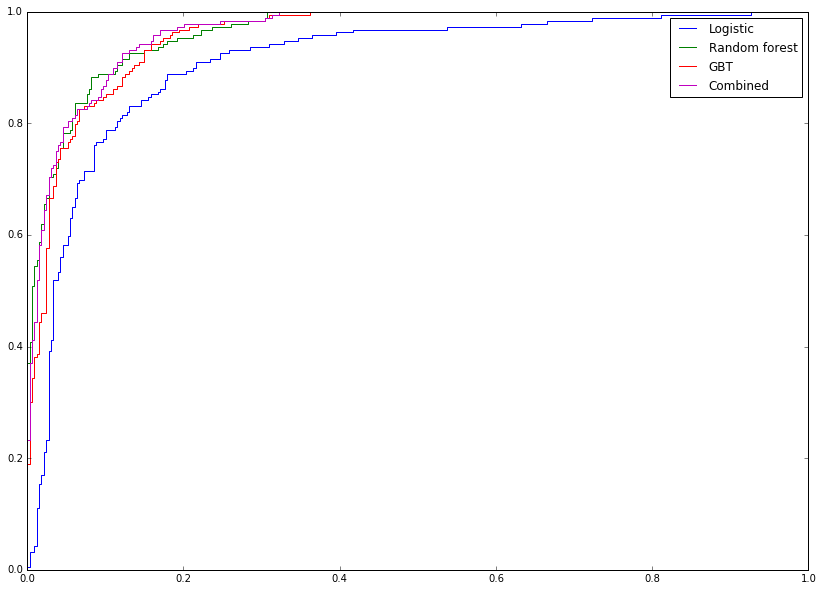

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr_log, tpr_log, _ = roc_curve(np.array(y_test.values), prediction_proba_log[:, 1])
fpr_rf, tpr_rf, _ = roc_curve(np.array(y_test.values), prediction_probaRF[:, 1])
fpr_gbt, tpr_gbt, _ = roc_curve(np.array(y_test.values), prediction_proba_gbt[:, 1])
fpr_combined, tpr_combined, _ = roc_curve(np.array(y_test.values), probability_combined)

plt.figure(figsize=(14,10))
plt.plot(fpr_log, tpr_log, 'b', label='Logistic')
plt.plot(fpr_rf, tpr_rf, 'g', label='Random forest')
plt.plot(fpr_gbt, tpr_gbt, 'r', label='GBT')
plt.plot(fpr_combined, tpr_combined, 'm', label='Combined')
plt.legend(loc=0)
plt.show()

# ROC curve and performances comparisons

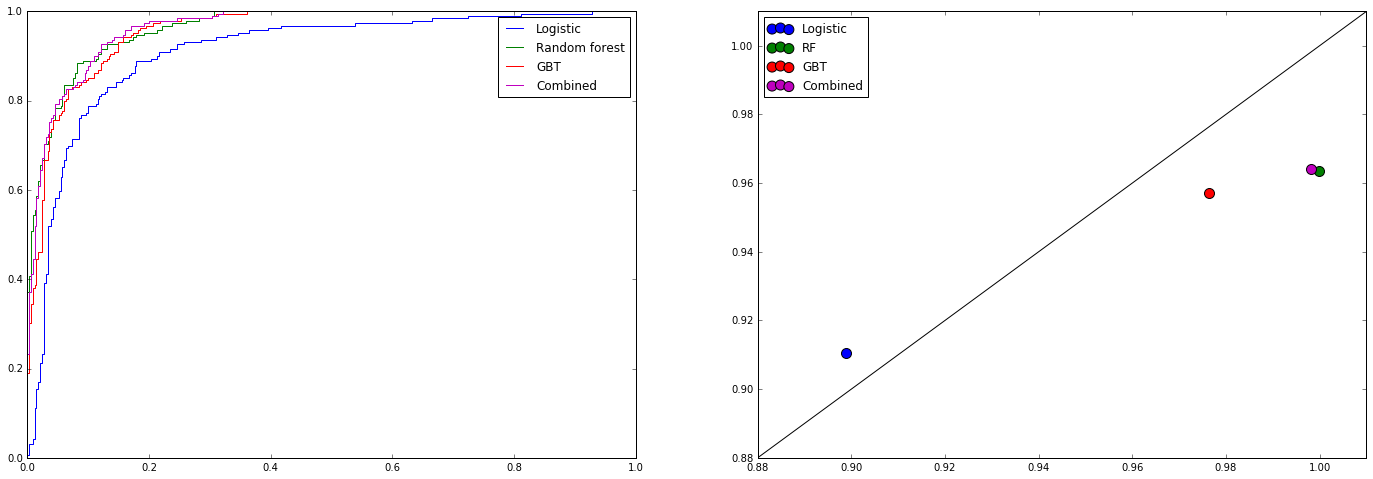

In [23]:
plt.figure(figsize=(24,8))

plt.subplot(121)
fpr_log, tpr_log, _ = roc_curve(np.array(y_test.values), prediction_proba_log[:, 1])
fpr_rf, tpr_rf, _ = roc_curve(np.array(y_test.values), prediction_probaRF[:, 1])
fpr_gbt, tpr_gbt, _ = roc_curve(np.array(y_test.values), prediction_proba_gbt[:, 1])
fpr_combined, tpr_combined, _ = roc_curve(np.array(y_test.values), probability_combined)
plt.plot(fpr_log, tpr_log, 'b', label='Logistic')
plt.plot(fpr_rf, tpr_rf, 'g', label='Random forest')
plt.plot(fpr_gbt, tpr_gbt, 'r', label='GBT')
plt.plot(fpr_combined, tpr_combined, 'm', label='Combined')
plt.legend(loc=0)

plt.subplot(122)
plt.scatter(roc_score_log_train, roc_score_log, label="Logistic", c="b", s=100)
plt.scatter(roc_scoreRF_train, roc_scoreRF, label="RF", c="g", s=100)
plt.scatter(roc_score_gbt_train, roc_score_gbt, label="GBT", c="r", s=100)
plt.scatter(combined_score_train, combined_score, label="Combined", c="m", s=100)
plt.plot([0, 1.01], [0,1.01], "k")
plt.xlim((0.88,1.01))
plt.ylim((0.88,1.01))
plt.legend(loc=2)

plt.show()

# Similarity in top features for RF & GBT

In [27]:
top_nb = 15
top_features_rf = [feature for feature, importance in feature_importances_rf[:top_nb]]
top_features_gbt = [feature for feature, importance in feature_importances_gbt[:top_nb]]

print("%50s | %50s" % ("Random Forest", "Gradient Boosted Trees"))
print("-"*103)
for feature_rf, feature_gbt in zip(top_features_rf, top_features_gbt):
    print("%50s | %50s" % (feature_rf, feature_gbt))

similarity = [1 if feature in top_features_gbt else 0 for feature in top_features_rf]
print("\nSimilarity: "+str(np.mean(similarity)))

                                     Random Forest |                             Gradient Boosted Trees
-------------------------------------------------------------------------------------------------------
                mean_Number.of.Unsuccessful.Grant. |                                              Month
      Contract.Value.Band...see.note.A.Reduced_MIA |                 mean_Number.of.Unsuccessful.Grant.
                 max_Number.of.Unsuccessful.Grant. |                                               Year
                        Contract.Value.Band.Values |                   mean_Number.of.Successful.Grant.
                                             Month |       Contract.Value.Band...see.note.A.Reduced_MIA
                  mean_Number.of.Successful.Grant. |                                            mean_B.
                 min_Number.of.Unsuccessful.Grant. |                         Contract.Value.Band.Values
                   max_Number.of.Successful.Grant. |            

# Parameters tuning (Grid Search)

In [ ]:
from sklearn.grid_search import GridSearchCV

parameters = {'n_estimators': [i for i in range(500, 1300, 100)], 'max_features': [i for i in range(1, 10)]}
GridsearchSVM = GridSearchCV(RandomForestClassifier(), parameters, cv=3, verbose=10, scoring='roc_auc', n_jobs=7)
GridsearchSVM.fit(X_train, y_train)

print(GridsearchSVM.best_params_, GridsearchSVM.best_score_)

# roc_auc_score(np.array(y_test.values), GridsearchSVM.best_estimator_.predict_proba(X_test)[:, 1])
# roc_auc_score(np.array(y_test.values), GridsearchSVM.best_estimator_.fit(X_train, y_train).predict_proba(X_test)[:, 1])

In [ ]:
X_train1, X_train2 = train1_df[features_without_nan], train2_df[features_without_nan]
y_train1, y_train2 = train1_df["Grant.Status"].astype(int), train2_df["Grant.Status"].astype(int)

In [ ]:
parameters = {'n_estimators': [i for i in range(1500, 2000, 100)], 'max_features': [i for i in range(12, 15)]}

best_score, best_params = grid_search_no_cv(parameters, X_train1, X_train2, y_train1, y_train2, RandomForestClassifier)
best_score, best_params

In [85]:
parameters = {'n_estimators': [i for i in range(1500, 2000, 100)], 'max_features': [i for i in range(12, 15)]}

best_score, best_params = grid_search_no_cv(parameters, X_train, X_test, y_train, y_test, RandomForestClassifier)

*  1/15 | 0.963735 | {'n_estimators': 1500, 'max_features': 12}
   2/15 | 0.962947 | {'n_estimators': 1600, 'max_features': 12}
*  3/15 | 0.963815 | {'n_estimators': 1700, 'max_features': 12}
   4/15 | 0.963260 | {'n_estimators': 1800, 'max_features': 12}
   5/15 | 0.963011 | {'n_estimators': 1900, 'max_features': 12}
   6/15 | 0.962866 | {'n_estimators': 1500, 'max_features': 13}
   7/15 | 0.963695 | {'n_estimators': 1600, 'max_features': 13}
   8/15 | 0.963027 | {'n_estimators': 1700, 'max_features': 13}
   9/15 | 0.963148 | {'n_estimators': 1800, 'max_features': 13}
  10/15 | 0.962754 | {'n_estimators': 1900, 'max_features': 13}
  11/15 | 0.962866 | {'n_estimators': 1500, 'max_features': 14}
  12/15 | 0.962762 | {'n_estimators': 1600, 'max_features': 14}
  13/15 | 0.963244 | {'n_estimators': 1700, 'max_features': 14}
  14/15 | 0.963003 | {'n_estimators': 1800, 'max_features': 14}
  15/15 | 0.962706 | {'n_estimators': 1900, 'max_features': 14}


In [84]:
parameters = {'n_estimators': [i for i in range(50, 550, 50)]}

best_score, best_params = grid_search_no_cv(parameters, X_train, X_test, y_train, y_test, GradientBoostingClassifier, parallel=False)

*  1/10 | 0.949695 | {'n_estimators': 50}
*  2/10 | 0.955179 | {'n_estimators': 100}
*  3/10 | 0.955678 | {'n_estimators': 150}
*  4/10 | 0.956771 | {'n_estimators': 200}
*  5/10 | 0.956948 | {'n_estimators': 250}
*  6/10 | 0.957704 | {'n_estimators': 300}
*  7/10 | 0.957833 | {'n_estimators': 350}
*  8/10 | 0.958926 | {'n_estimators': 400}
*  9/10 | 0.959007 | {'n_estimators': 450}
* 10/10 | 0.959152 | {'n_estimators': 500}


In [ ]:
best_score, best_params = grid_search_no_cv(parameters, X_train1, X_train2, y_train1, y_train2, GradientBoostingClassifier, parallel=False)